# Prediction Foot Project
Lorrain MORLET - Julien DE VOS


## Introduction

To introduce the prediction soccer contest, we aim to develop an AI model that can predict the outcome of soccer matches. The goal is to analyze historical data and identify patterns that can help us make accurate predictions.

The final objective of the project is to predict the outcome of Ligue 1 matches for the 2023-2024 season. To do this, we have access to data on Ligue 1 matches from the 2012-2013 season to the 2022-2023 season.

In this test, we will use some dataset containing information about various soccer matches, including team statistics, player performance, player appearance. Our objective is to train a machine learning model that can classify the result of a match as a win, loss, or draw.

By leveraging advanced algorithms and techniques, we can build a robust AI model that takes into account various factors such as team form, player stats, home advantage, and previous head-to-head records. This model will enable us to make informed predictions and gain valuable insights into the dynamics of soccer matches.

Let's dive into the exciting world of soccer matches prediction and unleash the power of AI in the realm of sports analytics!

## Imports

In [1]:
# all the necessary imports for the project

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import sklearn.discriminant_analysis as DA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt

import warnings

## Data Exploration

The first thing we do is importing the file `matchs_2013_2022.csv`, which contains the list of all the Ligue 1 matchs from 2012-2013 season to 2022-2023 season, with the results.

In [2]:
data = pd.read_csv("./data/matchs_2013_2022.csv")
data.head()

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,results
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,Stade Geoffroy-Guichard,31952.0,Antony Gautier,4-3-3 Attacking,4-2-3-1,AS Saint-Étienne,SC Bastia,2:2,domestic_league,0
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,Parc des Sports d’Annecy,8620.0,Philippe Kalt,4-4-2 double 6,4-4-2 double 6,Thonon Évian Grand Genève FC,EA Guingamp,1:2,domestic_league,-1
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,Stade du Hainaut,14874.0,Bartolomeu Varela,4-4-2 double 6,4-3-1-2,Valenciennes FC,Lille Olympique Sporting Club Lille Métropole,0:1,domestic_league,-1
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,Roazhon Park,13391.0,Benoît Millot,4-3-3 Attacking,4-2-3-1,Stade Rennais Football Club,Thonon Évian Grand Genève FC,0:0,domestic_league,0
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,Stade François-Coty,5981.0,Benoît Bastien,4-1-4-1,4-3-3 Defending,AC Ajaccio,Stade Rennais Football Club,3:1,domestic_league,1


In [3]:
features = ["attendance"] # List of features we will keep for the training
limit_date = '2024' # 2022-08-05 is the date of the first match of the 2022-2023 season

## Feature Engineering

Given that the aim of the model is to predict results for the 2023-2024 season on the basis of previous seasons. To estimate the effectiveness of our model, we will make predictions for the 2022-2023 season by training it on all the previous seasons.

The first feature we will add is the win percentage of each team depending on whether they are playing at home or away.

## Transformer Class definition

In [ ]:
import pandas as pd
import numpy as np

class DataProcessor:
    def __init__(self, X:pd.DataFrame, limit_date:str = None):
        self.X = X
        self.data = pd.read_csv("data/matchs_2013_2022.csv", sep=",")
        self.limit_date = limit_date if limit_date is not None else '9999'
        self.playerValuation = None
        self.teamComps = None
        self.dataTeams = None
        self.teams_stats_updated = {}
        self.stats_players = None
        self.playerAppearances = None
        self.features = []

    def get_club_win_percentage(self)->None:
        print(self.data.columns)
        print("get_club_win_percentage")
        for index, row in self.data.iterrows():
            # Home club win percentage at home
            # print(row['home_club_id'])
            home_club_id = row['home_club_id']
            matches_won_at_home = self.data[(self.data['home_club_id'] == home_club_id) & (self.data['date'] < limit_date)]['results'].value_counts().get(1, 0)
            total_matches_at_home = self.data[(self.data['home_club_id'] == home_club_id) & (self.data['date'] < limit_date)].shape[0]

            ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else np.nan
            
            # Update the row
            self.data.at[index, 'home_club_win_percentage'] = ratio

            # Away club win percentage away from home
            away_club_id = row['away_club_id']
            matches_won_away = self.data[(self.data['away_club_id'] == away_club_id) & (self.data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
            total_matches_away = self.data[(self.data['away_club_id'] == away_club_id) & (self.data['date'] < limit_date)].shape[0]
            
            ratio = matches_won_away / total_matches_away if total_matches_away != 0 else np.nan

            # Update the row
            self.data.at[index, 'away_club_win_percentage'] = ratio
            self.features.append('home_club_win_percentage')
            self.features.append('away_club_win_percentage')
            

    def get_win_percentage_of_manager(self):
        print("get_win_percentage_of_manager")
        for index, row in self.data.iterrows():
            # Home club manager win percentage at home
            home_club_manager_name = row['home_club_manager_name']
            matches_won_at_home = self.data[(self.data['home_club_manager_name'] == home_club_manager_name) & (self.data['date'] < self.limit_date)]['results'].value_counts().get(1, 0)
            total_matches_at_home = self.data[(self.data['home_club_manager_name'] == home_club_manager_name) & (self.data['date'] < self.limit_date)].shape[0]

            ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else np.nan
            
            # Update the row
            self.data.at[index, 'home_club_manager_win_percentage'] = ratio

            # Away club manager win percentage away from home
            away_club_manager_name = row['away_club_manager_name']
            matches_won_away = self.data[(self.data['away_club_manager_name'] == away_club_manager_name) & (self.data['date'] < self.limit_date)]['results'].value_counts().get(-1, 0)
            total_matches_away = self.data[(self.data['away_club_manager_name'] == away_club_manager_name) & (self.data['date'] < self.limit_date)].shape[0]

            ratio = matches_won_away / total_matches_away if total_matches_away != 0 else np.nan

            # Update the row
            self.data.at[index, 'away_club_manager_win_percentage'] = ratio
            
            self.features.append('home_club_manager_win_percentage')
            self.features.append('away_club_manager_win_percentage')

    def get_club_win_percentage_with_referee(self):
        print("get_club_win_percentage_with_referee")
        for index, row in self.data.iterrows():
            home_club_name = row['home_club_name']
            away_club_name = row['away_club_name']
            referee = row['referee']

            # Home club win percentage with this referee (at home or away)
            matches_won_with_referee = self.data[(self.data['home_club_name'] == home_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)]['results'].value_counts().get(1, 0)
            total_matches_with_referee = self.data[(self.data['home_club_name'] == home_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)].shape[0]

            matches_won_with_referee += self.data[(self.data['away_club_name'] == home_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)]['results'].value_counts().get(-1, 0)
            total_matches_with_referee += self.data[(self.data['away_club_name'] == home_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)].shape[0]

            ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else np.nan

            # Update the row
            self.data.at[index, 'home_club_win_percentage_with_referee'] = ratio

            # Away club win percentage with this referee (at home or away)
            matches_won_with_referee = self.data[(self.data['home_club_name'] == away_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)]['results'].value_counts().get(1, 0)
            total_matches_with_referee = self.data[(self.data['home_club_name'] == away_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)].shape[0]

            matches_won_with_referee += self.data[(self.data['away_club_name'] == away_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)]['results'].value_counts().get(-1, 0)
            total_matches_with_referee += self.data[(self.data['away_club_name'] == away_club_name) & (self.data['referee'] == referee) & (self.data['date'] < self.limit_date)].shape[0]

            ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else np.nan
            
            # Update the row
            self.data.at[index, 'away_club_win_percentage_with_referee'] = ratio
            
            features.append('home_club_win_percentage_with_referee')
            features.append('away_club_win_percentage_with_referee')
    
    def concatLists(self, liste:list[list[list]]) -> list[list]:
        return list(set([item for sublist in liste for item in sublist]))

    def get_score_player(self, id:int, limit_date:str) -> float:
        self.playerValuation = pd.read_csv("data\player_valuation_before_season.csv", sep=",") if self.playerValuation is None else self.playerValuation
        player = self.playerValuation[(self.playerValuation["player_id"] == id) & (self.playerValuation["date"] < limit_date)]["market_value_in_eur"].apply(lambda x: x/1e6)
        return player.mean() if len(player) > 0 else 0

    def get_score_team(self, team:int, limit_date:str) -> list:
        # Similar to self.get_score_team, refactor this method
        if(self.teamComps is None):
            lineups = pd.read_csv("data\game_lineups.csv", sep=",")
            self.teamComps = lineups.groupby(['club_id'])['player_id'].apply(list).reset_index()
            # print(self.teamComps)
            self.teamComps = self.teamComps.groupby(['club_id'])['player_id'].apply(list).apply(self.concatLists).reset_index()
            self.teamComps["score"] = self.teamComps["player_id"].apply(lambda x: sum([self.get_score_player(i, limit_date) for i in x]))
        return self.teamComps[self.teamComps["club_id"] == team]["score"].values[0]
        
    def convert_string_to_thousands(self, s)->float:
        # Similar to convert_string_to_thousands, refactor this method
        sign = 1 if s[0] != '-' else -1
        s = s.replace('-', '').replace('+', '')
        s = s[1:] if s[0] not in "1234567890" else s
        # print("process :", s)
        value = float(s[:-1] if len(s) > 1 else 0)
        multiplier = {'k': 1, 'm': 1000}.get(s[-1:], 1)
        # Return the numeric value multiplied by the multiplier
        return value * multiplier * sign

    def get_stats_all_players(self):
        if(self.playerAppearances is None):
            self.playerAppearances = pd.read_csv("data\player_appearance.csv", sep=",")
        
        player_stats = self.playerAppearances.groupby('player_id').agg({
            'goals': ['mean', 'sum'],
            'assists': ['mean', 'sum'],
            'minutes_played': 'mean',
            'yellow_cards': ['mean', 'sum'],
            'red_cards': ['mean', 'sum'],
            'appearance_id': 'count'
        }).rename(columns={
            'goals': 'avg_goals_per_game total_goals',
            'assists': 'avg_assists_per_game total_assists',
            'minutes_played': 'avg_minutes_played_per_game',
            'yellow_cards': 'avg_yellow_cards_per_game total_yellow_cards',
            'red_cards': 'avg_red_cards_per_game total_red_cards',
            'appearance_id': 'total_games'
        })
        
        player_stats.columns = [col[0] for col in player_stats.columns.to_flat_index()]
        
        column_parts = [col.split() for col in player_stats.columns]
        new_column_names = []
        for i, parts in enumerate(column_parts):
            if (i > 0 and parts[0] == column_parts[i-1][0]):
                new_column_names.append(parts[1] if (len(parts) > 1) else parts[0])
            else:
                new_column_names.append(parts[0])
        player_stats.columns = new_column_names
        
        return player_stats

    def get_list_players(self, team_id, limit_date:str = None):
        if(self.playerAppearances is None):
            self.playerAppearances = pd.read_csv("data\player_appearance.csv", sep=",")
        
        players_ids = self.playerAppearances[(self.playerAppearances["player_current_club_id"] == team_id) & (self.playerAppearances['date'] < limit_date)]["player_id"]
        players_ids = players_ids.drop_duplicates()
        return list(players_ids)

    def get_players_team_stats(self, team_id:str, limit_date:str):
        if(self.stats_players is None):
            self.stats_players = self.get_stats_all_players()
        
        players_ids = self.get_list_players(team_id, limit_date)
        # print(f'players_ids : {players_ids}')
        return self.stats_players[self.stats_players.index.isin(players_ids)]

    def exp_log_fn(self, x, num_games):
        return np.exp(x * np.log(num_games+1)) * 10 - 10

    def get_players_team_stats_updated(self, team_id:str, limit_date:str):
        if(team_id in self.teams_stats_updated):
            print("team_id in self.teams_stats_updated")
            return self.teams_stats_updated[team_id]
        self.stats_players = self.get_players_team_stats(team_id, limit_date)
        
        columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
        updated_columns = [f"{col}_updated" for col in columns]
        self.stats_players[[f"{col}_updated" for col in columns]] = self.stats_players[columns].apply(self.exp_log_fn, args = (self.stats_players["total_games"], ))
        self.stats_players.drop(columns=["avg_minutes_played_per_game"])
        self.teams_stats_updated[team_id] = self.stats_players
        return self.stats_players

    def get_updated_stats_players_team_mean(self, team_id:str, limit_date:str):
        # Similar to get_updated_stats_players_team_mean, refactor this method
        self.stats_players = self.get_players_team_stats_updated(team_id, limit_date)
        # print(self.stats_players)
        columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
        # print(self.)
        # print(self.stats_players[[f"{col}_updated" for col in columns]].mean())
        return self.stats_players[[f"{col}_updated" for col in columns]].mean() 

    def add_updated_stats_players_team_mean(self):
        columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
        self.data[[f"home_club_{col}_updated" for col in columns]] = self.data["home_club_id"].apply(lambda team: self.get_updated_stats_players_team_mean(team, self.limit_date))
        self.data[[f"away_club_{col}_updated" for col in columns]] = self.data["away_club_id"].apply(lambda team: self.get_updated_stats_players_team_mean(team, self.limit_date))
        for col in columns:
            self.features.append(f"home_club_{col}_updated")
            self.features.append(f"away_club_{col}_updated")
        
    def add_price_players(self):
        if(self.dataTeams is None):
            self.dataTeams = pd.read_csv("data\clubs_fr.csv", sep=",")
            
        self.dataTeams["transfer_num"] = self.dataTeams["net_transfer_record"].apply(self.convert_string_to_thousands)
        
        dataTemp = self.data.merge(self.dataTeams[['club_id', 'transfer_num']],
                                        left_on='home_club_id',
                                        right_on='club_id',
                                        how='left')#.rename(columns={'transfer_num': 'transfer_home_team'})
        self.data["transfer_home_team"] = dataTemp["transfer_num"]
        dataTemp = self.data.merge(self.dataTeams[['club_id', 'transfer_num']],
                                        left_on='away_club_id',
                                        right_on='club_id',
                                        how='left')#.rename(columns={'transfer_num': 'transfer_away_team'})
        self.data["transfer_away_team"] = dataTemp["transfer_num"]
        self.features.append("transfer_home_team")
        self.features.append("transfer_away_team")

    def add_club_scores(self):
        # Similar to add_club_scores, refactor this method
        self.data["score_away_team"] = self.data["away_club_id"].apply(lambda team: self.get_score_team(team, self.limit_date))
        self.data["score_home_team"] = self.data["home_club_id"].apply(lambda team: self.get_score_team(team, self.limit_date))
        self.features.append("score_away_team")
        self.features.append("score_home_team")


    def get_features(self):
        return list(set(self.features))
    
    def process_data(self):
        self.get_club_win_percentage()
        self.get_win_percentage_of_manager()
        self.get_club_win_percentage_with_referee()
        self.add_club_scores()
        self.add_price_players()
        # self.add_updated_stats_players_team_mean()

        self.X = self.data[list(set(self.features))]
        
        return self.X

    

In [ ]:
# data = pd.read_csv("./data/matchs_2013_2022.csv")
transformer = DataProcessor(data=pd.read_csv("./data/matchs_2013_2022.csv"), limit_date=limit_date)
new_data = transformer.process_data()
features = list(set(transformer.get_features()))
print('features : ', features)
print(new_data.head())
# print(data.head())

Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'results'],
      dtype='object')
get_club_win_percentage
get_win_percentage_of_manager
get_club_win_percentage_with_referee


C:\Users\lorra\AppData\Local\Temp\ipykernel_26400\1779856948.py:115: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lineups = pd.read_csv("data\game_lineups.csv", sep=",")


features :  ['score_away_team', 'home_club_manager_win_percentage', 'away_club_manager_win_percentage', 'away_club_win_percentage', 'home_club_win_percentage', 'transfer_away_team', 'score_home_team', 'transfer_home_team']
   Unnamed: 0  game_id  season         round        date  home_club_id  \
0          12  2330874    2013   8. Matchday  2013-09-28           618   
1          13  2330880    2013  10. Matchday  2013-10-19         14171   
2          14  2330916    2013  15. Matchday  2013-11-30          1423   
3          15  2331018    2013  21. Matchday  2014-01-18           273   
4          16  2331034    2013  24. Matchday  2014-02-08          1147   

   away_club_id  home_club_goals  away_club_goals  home_club_position  ...  \
0           595                2                2                 6.0  ...   
1           855                1                2                16.0  ...   
2          1082                0                1                18.0  ...   
3         14171     

In [ ]:
data = new_data
print(data.columns)
data.head()

Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'results',
       'home_club_win_percentage', 'away_club_win_percentage',
       'home_club_manager_win_percentage', 'away_club_manager_win_percentage',
       'home_club_win_percentage_with_referee',
       'away_club_win_percentage_with_referee', 'score_away_team',
       'score_home_team', 'transfer_home_team', 'transfer_away_team'],
      dtype='object')


,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,home_club_win_percentage,away_club_win_percentage,home_club_manager_win_percentage,away_club_manager_win_percentage,home_club_win_percentage_with_referee,away_club_win_percentage_with_referee,score_away_team,score_home_team,transfer_home_team,transfer_away_team
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,0.467391,0.168421,0.571429,0.166667,0.217391,0.333333,81.567038,188.724000,12850.0,480.0
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,0.350877,0.192982,0.393939,0.254237,0.428571,0.200000,74.769105,31.855883,0.0,3700.0
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,0.342105,0.369458,0.214286,0.276923,0.200000,0.500000,244.679289,23.689626,2520.0,3650.0
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,0.480392,0.210526,0.313433,0.178218,0.461538,0.200000,31.855883,371.824554,62100.0,0.0
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,0.245614,0.318627,0.166667,0.338235,0.500000,0.387097,371.824554,57.169593,0.0,62100.0


      score_away_team  home_club_manager_win_percentage  \
0           81.567038                          0.571429   
1           74.769105                          0.393939   
2          244.679289                          0.214286   
3           31.855883                          0.313433   
4          371.824554                          0.166667   
...               ...                               ...   
4073       503.488523                          0.277778   
4074       220.216176                          0.325843   
4075       144.491748                          0.306667   
4076       144.491748                          0.400000   
4077        88.145685                          0.500000   

      away_club_manager_win_percentage  away_club_win_percentage  \
0                             0.166667                  0.168421   
1                             0.254237                  0.192982   
2                             0.276923                  0.369458   
3                  

C:\Users\lorra\AppData\Local\Temp\ipykernel_26400\1314349916.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('date', inplace=True, axis=1) if 'date' in data.columns else None


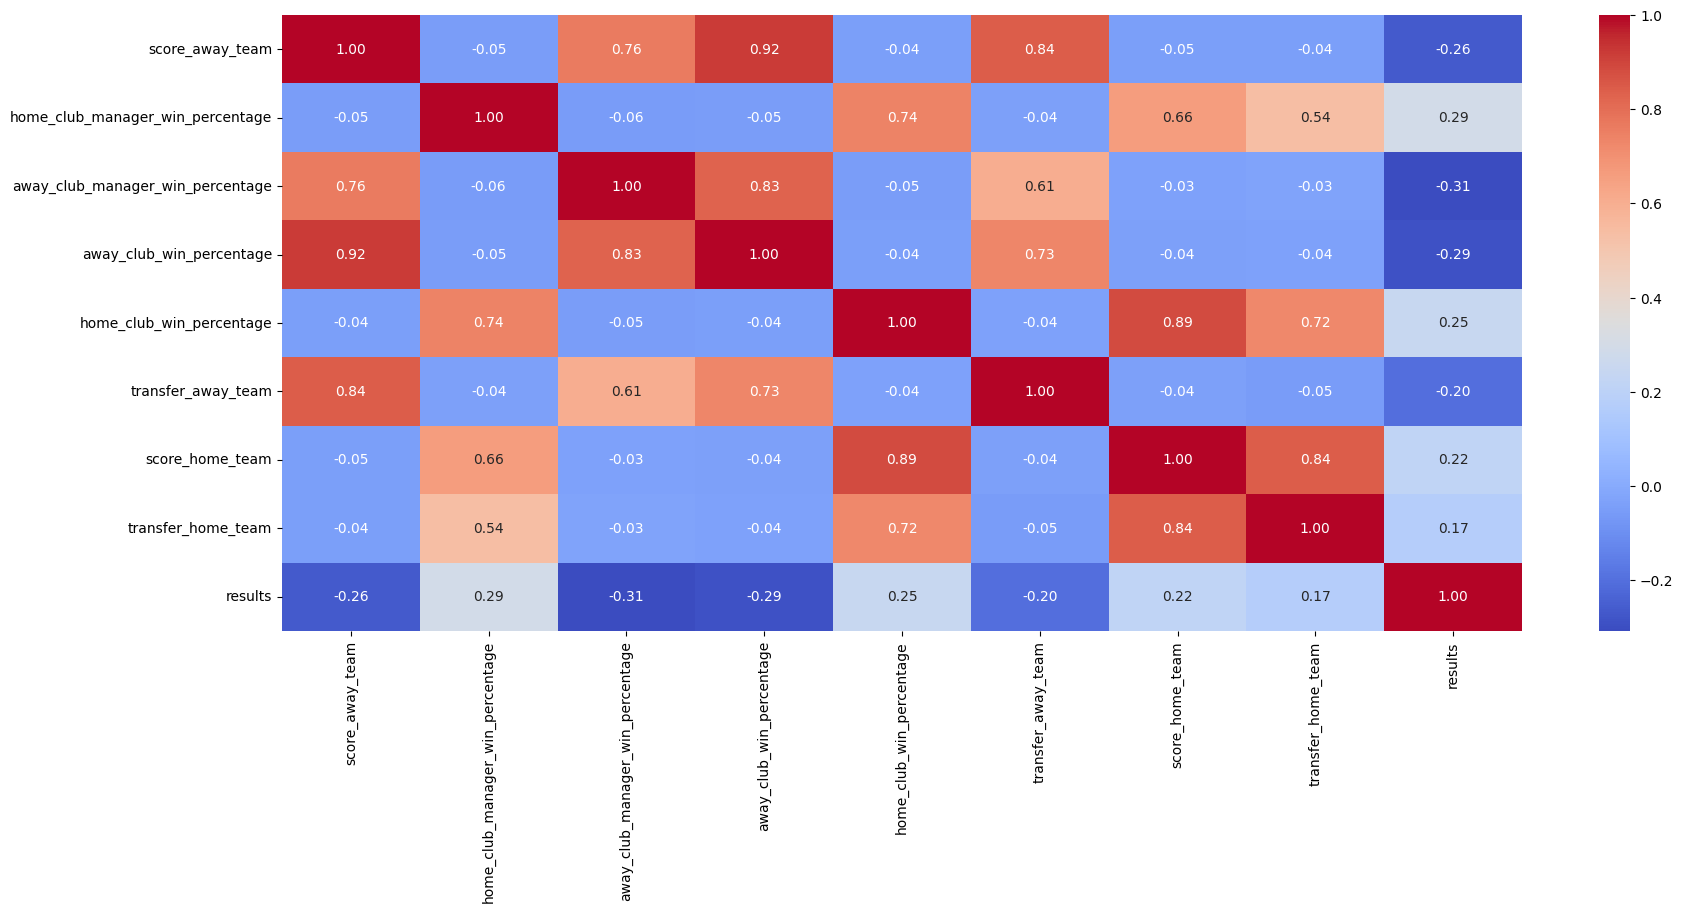

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data['results'], test_size=0.2, random_state=42)

X_train.drop(['date', 'results'], axis=1, inplace=True) if 'date' in X_train.columns else None
X_test.drop(['date', 'results'], axis=1, inplace=True) if 'date' in X_test.columns else None

X_train.head()

data = data[features + ['date', 'results']] 

import seaborn as sns

def plot_correlation_matrix(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

data.drop('date', inplace=True, axis=1) if 'date' in data.columns else None
print(data)

corr_mat = pd.DataFrame(data)
corr_mat['results'] = data['results']
plot_correlation_matrix(corr_mat)

Dropping the most useless columns

In [ ]:
print(data.columns)
print(features)

Index(['score_away_team', 'home_club_manager_win_percentage',
       'away_club_manager_win_percentage', 'away_club_win_percentage',
       'home_club_win_percentage', 'transfer_away_team', 'score_home_team',
       'transfer_home_team', 'results'],
      dtype='object')
['score_away_team', 'home_club_manager_win_percentage', 'away_club_manager_win_percentage', 'away_club_win_percentage', 'home_club_win_percentage', 'transfer_away_team', 'score_home_team', 'transfer_home_team']


In [ ]:
correlation_matrix = data.corr()

columns_to_drop = correlation_matrix.columns[correlation_matrix['results'].abs() <= 0.2]
print(columns_to_drop)

data = data.drop(columns=columns_to_drop)
for col in columns_to_drop:
    features.remove(col) if col in features else None
features

Index(['transfer_home_team'], dtype='object')


['score_away_team',
 'home_club_manager_win_percentage',
 'away_club_manager_win_percentage',
 'away_club_win_percentage',
 'home_club_win_percentage',
 'transfer_away_team',
 'score_home_team']

In [ ]:
X_train = SimpleImputer(strategy='mean').fit_transform(X_train)
X_test = SimpleImputer(strategy='mean').fit_transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Selection and Training

In [ ]:
# from fonctions_tests import test_data, test_data_before_2023, get_accuracy_with_model

# Define the names of the classifications method
names = ["LogisticRegression",
         "NBayes",
         "LDA",
         "QDA",
         "KNN",
          "SVM linear",
         "SVM rbf",
         "SVM sigmoid",
         "RandomForest",
         "DecisionTree"]

# Define the classifiers
classifiers = [LogisticRegression(C=1e5),
               GaussianNB(),
               DA.LinearDiscriminantAnalysis(),
               DA.QuadraticDiscriminantAnalysis(),
               KNeighborsClassifier(n_neighbors=5),
                SVC(kernel='linear', C=1.0),
               SVC(kernel='rbf', gamma = 1e-4),
               SVC(kernel='sigmoid', gamma = 1e-4),
               RandomForestClassifier(),
               DecisionTreeClassifier()]

scores = []
scores_before = []

# Loop through all different classfication methods
for name, clf in zip(names, classifiers):
    
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

    print("\tAccuracy with", name, " : ", round(accuracy,3))

# print("test with all data before 2022, to predict the 2022 season")
# for name, clf in zip(names, classifiers):
#     accuracy = test_data_before_2023(data, model=clf)
#     scores_before.append(accuracy)
#     print("\tAccuracy with ", name, " : ", round(accuracy,3))

	Accuracy with LogisticRegression  :  0.554
	Accuracy with NBayes  :  0.496
	Accuracy with LDA  :  0.55
	Accuracy with QDA  :  0.527
	Accuracy with KNN  :  0.46
	Accuracy with SVM linear  :  0.547
	Accuracy with SVM rbf  :  0.482
	Accuracy with SVM sigmoid  :  0.46
	Accuracy with RandomForest  :  0.451
	Accuracy with DecisionTree  :  0.418


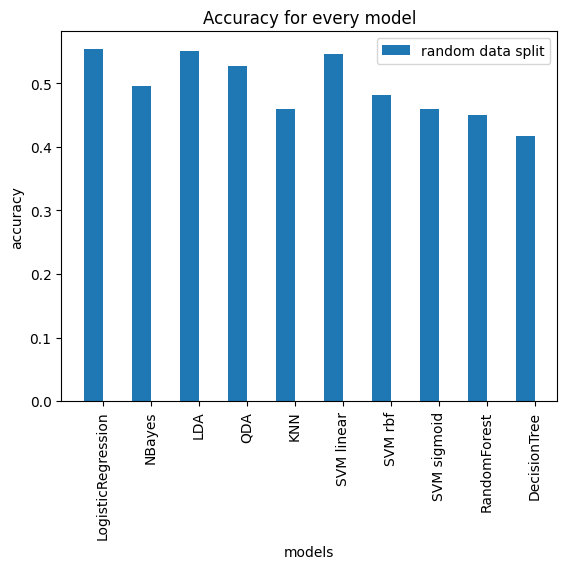

In [ ]:
X_axis = np.arange(len(names)) 

plt.bar(X_axis - 0.2, scores, 0.4, label = 'random data split')
# plt.bar(X_axis + 0.2, scores_before, 0.4, label = 'before 2022 split')
  
plt.xticks(X_axis, names, rotation=90) 
plt.xlabel("models") 
plt.ylabel("accuracy") 
plt.title("Accuracy for every model") 
plt.legend()
plt.show()

We can see that the bests models are : SVM linear, Logistic regression, and LDA. Therefore, we'll try to optimize the best one : SVM Linear.

Let's now find some hyperparameters for this model ! 

Index(['score_away_team', 'home_club_manager_win_percentage',
       'away_club_manager_win_percentage', 'away_club_win_percentage',
       'home_club_win_percentage', 'transfer_away_team', 'score_home_team',
       'results'],
      dtype='object')
fini with c =  0.01
fini with c =  0.1
fini with c =  1
fini with c =  10
fini with c =  100

Accuracies :  [(0.01, 0.5404411764705882), (0.1, 0.5477941176470589), (1, 0.5465686274509803), (10, 0.5465686274509803), (100, 0.5465686274509803)]


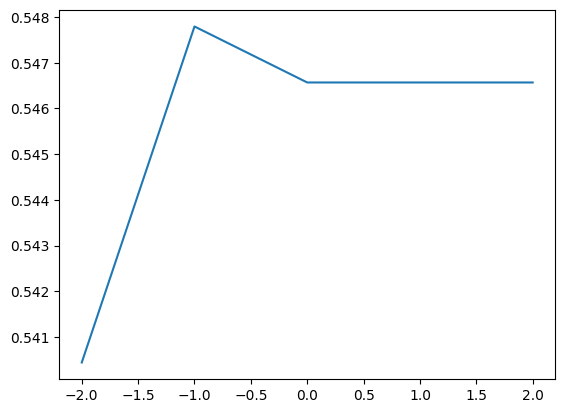

In [ ]:
cv = 7
batch_size = 0.6
all_accuracies = {}
accuracies = []
sizes = [0.01, 0.1, 1, 10, 100]

print(data.columns)

for c in sizes:
    for i in range(cv):
        clf = SVC(kernel='linear', C=c)
        clf.fit(X_train, y_train.values.ravel())
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if(c not in all_accuracies): all_accuracies[c] = []
        all_accuracies[c].append(accuracy)
        # print("\tAccuracy with ", name, " : ", round(accuracy,3))
    accuracies.append(np.mean(all_accuracies[c]))
    print('fini with c = ', c)

print("\nAccuracies : ", list(zip(sizes, accuracies)))

plt.plot(np.log10(sizes), accuracies)

In [ ]:
model = SVC(kernel='linear', C=1.0)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Score en entrainenement : {accuracy_score(y_true=y_train, y_pred=y_pred_train)}")
print(f"Score en test : {accuracy_score(y_true=y_test, y_pred=y_pred_test)}")

Score en entrainenement : 0.5282035561005518
Score en test : 0.5465686274509803


In [ ]:
matchs_2023 = pd.read_csv("data\match_2023.csv")
# J’applique le même traitement que mon fichier entraînement

X = transformer.process_data()
X.drop(columns=columns_to_drop, inplace=True) if len(columns_to_drop) > 0 else None

X.tail()

Index(['game_id', 'date', 'home_club_id', 'away_club_id',
       'home_club_manager_name', 'away_club_manager_name', 'stadium',
       'attendance', 'referee', 'home_club_name', 'away_club_name',
       'competition_type'],
      dtype='object')
get_club_win_percentage


KeyError: 'results'

In [ ]:
preds = model.predict(X)
print(preds)